# Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.model_zoo as model_zoo
import numpy as np
from PIL import Image
from torch.utils import data
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
import random
import torch.optim as opt
from tqdm import tqdm
import time

import os
from torchsummary import summary
import cv2
from sklearn.model_selection import train_test_split

import copy
from collections import defaultdict

import re
import math

# Helper

In [2]:
def read_images(root_path): 
  """ 
    Args : directory path
    Return : list with file path
  """

  for root, dirs, files in os.walk(root_path):
    print("path：", root)
    print("directory：", dirs)
    print("file：", files)
    
  org_imgs = [(root + "/" + file_name) for file_name in tqdm(files)]
  org_imgs.sort()
  print("Read ",len(org_imgs), " files")
  return org_imgs

def make_cm2lbl():

  colormap = [[0,0,0], [0,0,128], [0,128,128], [128,0,0], [0,128,0]] # background, grider, net, lanyard, guardrail 

  cm2lbl = np.zeros(256**3) # for each pixel 0~255 , channel = 3(RGB)
  for i,cm in enumerate(colormap):
      cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i
      # print(i)
      # print((cm[0]*256+cm[1])*256+cm[2]
  return cm2lbl


def image2label(img, cm2lbl):
  data = np.array(img, dtype='int32')
  idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
  # print(np.unique(idx))
  # print(cm2lbl[idx])
  result = np.array(cm2lbl[idx], dtype='int64')  
  return result[:,:,None]

# helper function for data visualization
def visualize(**images):
  """PLot images in one row."""
  n = len(images)
  plt.figure(figsize=(16, 5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

def print_network(net):
  num_params = 0
  for param in net.parameters():
    num_params += param.numel()
  print(net)
  print('Total number of parameters: %d' % num_params)

# Dataset

In [3]:
train_features_folder = "/home/user/Desktop/lanyard_segmentation/guardrail/train_data/features_cropped"
train_labels_folder = "/home/user/Desktop/lanyard_segmentation/guardrail/train_data/labels_cropped"

In [4]:
# transformer
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomAffine(degrees=0, translate=(0.005, 0.0025)),
])
transform_toTensor = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class IS_Dataset(Dataset):
  CLASSES = ['background', 'girder', 'net', 'lanyard', 'guardrail']
  def __init__(self, data_list, label_list, classes, cm2lbl, transform=None, transform_toTensor=None, resize_size=(512, 512)):

    self.data_list = data_list
    self.label_list = label_list
    self.transform = transform
    self.transform_toTensor = transform_toTensor
    self.cm2lbl = cm2lbl
    self.resize_size = resize_size
    # convert str names to class values on masks
    self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    print('Read ' + str(len(self.data_list)) + ' images')
    
  def __getitem__(self, index):
    # read data
    image = cv2.imread(self.data_list[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, self.resize_size, interpolation=cv2.INTER_AREA)
        
    mask = cv2.imread(self.label_list[index])
    mask = cv2.resize(mask, self.resize_size, interpolation=cv2.INTER_NEAREST)

    # apply data augmentations
    if self.transform:
      # ndarray to PIL image
      image = Image.fromarray(image)
      mask = Image.fromarray(mask)
      # apply the transforms
      image = self.transform(image)
      mask = self.transform(mask)

    mask = image2label(mask, self.cm2lbl)
    mask = mask.squeeze()
    # print(np.unique(mask))
    # print(mask.shape)
    
    masks = [(mask == v) for v in self.class_values]
    mask = np.stack(masks, axis=-1).astype('float')

    if self.transform_toTensor:
      image = self.transform_toTensor(image)
      mask = self.transform_toTensor(mask)

    return image, mask
    
  def __len__(self):
    return len(self.data_list)

In [6]:
input_imgs = read_images(train_features_folder)
output_imgs = read_images(train_labels_folder)
classes = ["guardrail"]
cm2lbl = make_cm2lbl()


path： /home/user/Desktop/lanyard_segmentation/guardrail/train_data/features_cropped
directory： []
file： ['0001_4.png', '0079_7.png', '0048_9.png', '0087_7.png', '0010_10.png', '0047_9.png', '0042_1.png', '0051_7.png', '0060_6.png', '0039_7.png', '0002_8.png', '0028_8.png', '0011_10.png', '0024_1.png', '0013_6.png', '0058_3.png', '0017_9.png', '0065_10.png', '0046_5.png', '0026_5.png', '0056_9.png', '0043_10.png', '0036_1.png', '0032_7.png', '0057_1.png', '0074_6.png', '0025_8.png', '0020_2.png', '0079_6.png', '0064_4.png', '0047_1.png', '0066_4.png', '0080_5.png', '0071_9.png', '0065_9.png', '0051_8.png', '0031_6.png', '0044_9.png', '0020_7.png', '0019_6.png', '0016_4.png', '0017_10.png', '0059_9.png', '0015_4.png', '0045_9.png', '0051_4.png', '0029_9.png', '0082_10.png', '0030_8.png', '0023_2.png', '0079_9.png', '0019_3.png', '0013_4.png', '0002_3.png', '0047_6.png', '0002_1.png', '0057_7.png', '0040_3.png', '0010_1.png', '0012_4.png', '0079_4.png', '0050_8.png', '0067_7.png', '0006_5

100%|██████████| 792/792 [00:00<00:00, 3209554.37it/s]


Read  792  files
path： /home/user/Desktop/lanyard_segmentation/guardrail/train_data/labels_cropped
directory： []
file： ['0001_4.png', '0079_7.png', '0048_9.png', '0087_7.png', '0010_10.png', '0047_9.png', '0042_1.png', '0051_7.png', '0060_6.png', '0039_7.png', '0002_8.png', '0028_8.png', '0011_10.png', '0024_1.png', '0013_6.png', '0058_3.png', '0017_9.png', '0065_10.png', '0046_5.png', '0026_5.png', '0056_9.png', '0043_10.png', '0036_1.png', '0032_7.png', '0057_1.png', '0074_6.png', '0025_8.png', '0020_2.png', '0079_6.png', '0064_4.png', '0047_1.png', '0066_4.png', '0080_5.png', '0071_9.png', '0065_9.png', '0051_8.png', '0031_6.png', '0044_9.png', '0020_7.png', '0019_6.png', '0016_4.png', '0017_10.png', '0059_9.png', '0015_4.png', '0045_9.png', '0051_4.png', '0029_9.png', '0082_10.png', '0030_8.png', '0023_2.png', '0079_9.png', '0019_3.png', '0013_4.png', '0002_3.png', '0047_6.png', '0002_1.png', '0057_7.png', '0040_3.png', '0010_1.png', '0012_4.png', '0079_4.png', '0050_8.png', '0067_

100%|██████████| 792/792 [00:00<00:00, 3266360.64it/s]

Read  792  files


In [7]:
input_train, input_vali, output_train, output_vali = train_test_split(input_imgs, output_imgs, test_size=0.2, random_state=42)
train_dataset_vis = IS_Dataset(input_train, output_train, classes=classes, cm2lbl=cm2lbl)
validation_dataset_vis = IS_Dataset(input_vali, output_vali, classes=classes, cm2lbl=cm2lbl)

Read 633 images
Read 159 images


(512, 512, 3)
(512, 512, 1)


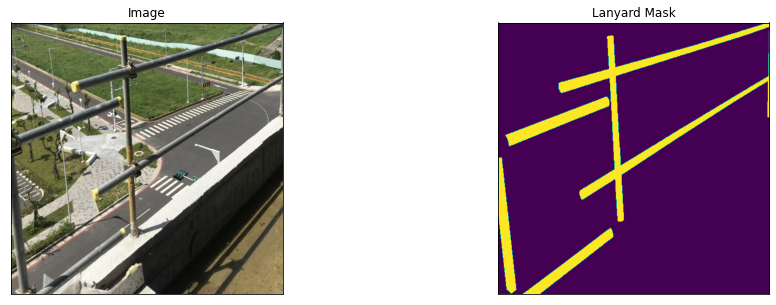

In [8]:
image, mask = train_dataset_vis[300]
print(image.shape)
print(mask.shape)
visualize(
    image=image, 
    lanyard_mask=mask[..., 0].squeeze(),
)

# Model

In [23]:
class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True, is_relu6=False):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = math.ceil(oup / ratio)
        new_channels = init_channels*(ratio-1)
        if is_relu6:
            self.primary_conv = nn.Sequential(
                nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
                nn.BatchNorm2d(init_channels),
                nn.ReLU6(inplace=True) if relu else nn.Sequential(),
            )

            self.cheap_operation = nn.Sequential(
                nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size//2, groups=init_channels, bias=False),
                nn.BatchNorm2d(new_channels),
                nn.ReLU6(inplace=True) if relu else nn.Sequential(),
            )
        else:
            self.primary_conv = nn.Sequential(
                nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
                nn.BatchNorm2d(init_channels),
                nn.ReLU(inplace=True) if relu else nn.Sequential(),
            )

            self.cheap_operation = nn.Sequential(
                nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size//2, groups=init_channels, bias=False),
                nn.BatchNorm2d(new_channels),
                nn.ReLU(inplace=True) if relu else nn.Sequential(),
            )            
    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1,x2], dim=1)
        return out[:,:self.oup,:,:]

In [24]:
def conv_bn(inp, oup, stride, BatchNorm):
    return nn.Sequential(
        GhostModule(inp, oup, kernel_size=3, stride=stride, relu=True, is_relu6=True)
#         nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
#         BatchNorm(oup),
#         nn.ReLU6(inplace=True)
    )


def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, dilation, expand_ratio, BatchNorm):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup
        self.kernel_size = 3
        self.dilation = dilation

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 0, dilation, groups=hidden_dim, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, 1, 1, bias=False),
                BatchNorm(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, 1, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 0, dilation, groups=hidden_dim, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, 1, bias=False),
                BatchNorm(oup),
            )

    def forward(self, x):
        x_pad = fixed_padding(x, self.kernel_size, dilation=self.dilation)
        if self.use_res_connect:
            x = x + self.conv(x_pad)
        else:
            x = self.conv(x_pad)
        return x


class MobileNetV2(nn.Module):
    def __init__(self, output_stride=16, BatchNorm=None, width_mult=1., pretrained=False):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        current_stride = 1
        rate = 1
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = int(input_channel * width_mult)
        self.features = [conv_bn(3, input_channel, 2, BatchNorm)]
        current_stride *= 2
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            if current_stride == output_stride:
                stride = 1
                dilation = rate
                rate *= s
            else:
                stride = s
                dilation = 1
                current_stride *= s
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, stride, dilation, t, BatchNorm))
                else:
                    self.features.append(block(input_channel, output_channel, 1, dilation, t, BatchNorm))
                input_channel = output_channel
        self.features = nn.Sequential(*self.features)
        self._initialize_weights()

        if pretrained:
            self._load_pretrained_model()

        self.low_level_features = self.features[0:4]
        self.high_level_features = self.features[4:]

    def forward(self, x):
        low_level_feat = self.low_level_features(x)
        x = self.high_level_features(low_level_feat)
        return x, low_level_feat

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('http://jeff95.me/models/mobilenet_v2-6a65762b.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            # elif isinstance(m, SynchronizedBatchNorm2d):
            #     m.weight.data.fill_(1)
            #     m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


In [25]:

class ASPP_module(nn.Module):
    def __init__(self, inplanes, planes, rate):
        super(ASPP_module, self).__init__()
        if rate == 1:
            kernel_size = 1
            padding = 0
        else:
            kernel_size = 3
            padding = rate
        self.atrous_convolution = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=rate, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()

        self.__init_weight()

    def forward(self, x):
        x = self.atrous_convolution(x)
        x = self.bn(x)

        return self.relu(x)

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [26]:
class DeepLabv3_plus_mobilenet(nn.Module):
    def __init__(self, nInputChannels=3, n_classes=21, os=16, pretrained=False, _print=True):
        if _print:
            print("Constructing DeepLabv3+ model...")
            print("Number of classes: {}".format(n_classes))
            print("Output stride: {}".format(os))
            print("Number of Input Channels: {}".format(nInputChannels))
        super(DeepLabv3_plus_mobilenet, self).__init__()

        # Atrous Conv
        self.efficient_features = MobileNetV2(output_stride=16, BatchNorm=nn.BatchNorm2d)

        # ASPP
        if os == 16:
            rates = [1, 6, 12, 18]
        elif os == 8:
            rates = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = ASPP_module(320, 256, rate=rates[0])
        self.aspp2 = ASPP_module(320, 256, rate=rates[1])
        self.aspp3 = ASPP_module(320, 256, rate=rates[2])
        self.aspp4 = ASPP_module(320, 256, rate=rates[3])

        self.relu = nn.ReLU()

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             GhostModule(320, 256, kernel_size=1, stride=1, relu=True)
#                                              nn.Conv2d(320, 256, 1, stride=1, bias=False),
#                                              nn.BatchNorm2d(256),
#                                              nn.ReLU()
                                            )

        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        # adopt [1x1, 48] for channel reduction.
        self.conv2 = nn.Conv2d(24, 48, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(48)

        self.last_conv = nn.Sequential(GhostModule(304, 256, kernel_size=3, stride=1, relu=True),
                                       GhostModule(256, 256, kernel_size=3, stride=1, relu=True),
#             nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
#                                        nn.BatchNorm2d(256),
#                                        nn.ReLU(),
#                                        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
#                                        nn.BatchNorm2d(256),
#                                        nn.ReLU(),
                                       nn.Conv2d(256, n_classes, kernel_size=1, stride=1))

    def forward(self, input):
        x, low_level_features = self.efficient_features(input)
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.upsample(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = F.upsample(x, size=(int(math.ceil(input.size()[-2]/4)),
                                int(math.ceil(input.size()[-1]/4))), mode='bilinear', align_corners=True)

        low_level_features = self.conv2(low_level_features)
        low_level_features = self.bn2(low_level_features)
        low_level_features = self.relu(low_level_features)


        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)
        x = F.upsample(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                # torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()





In [27]:
def get_1x_lr_params(model):
    """
    This generator returns all the parameters of the net except for
    the last classification layer. Note that for each batchnorm layer,
    requires_grad is set to False in deeplab_resnet.py, therefore this function does not return
    any batchnorm parameter
    """
    b = [model.xception_features]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k


def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last layer of the net,
    which does the classification of pixel into classes
    """
    b = [model.aspp1, model.aspp2, model.aspp3, model.aspp4, model.conv1, model.conv2, model.last_conv]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

In [28]:
model = DeepLabv3_plus_mobilenet(nInputChannels=3, n_classes=1, os=16, pretrained=False, _print=True)
model.eval()
image = torch.randn(1, 3, 512, 512)
with torch.no_grad():
  output = model.forward(image)
print(output.size())

Constructing DeepLabv3+ model...
Number of classes: 1
Output stride: 16
Number of Input Channels: 3
torch.Size([1, 1, 512, 512])


/home/user/anaconda3/envs/jamie_segmentation/lib/python3.6/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [29]:
print_network(model)

DeepLabv3_plus_mobilenet(
  (efficient_features): MobileNetV2(
    (features): Sequential(
      (0): Sequential(
        (0): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (cheap_operation): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
        )
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=Tr

# Train

In [30]:
# metrics
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=1):
  with torch.no_grad():
    pred_mask = F.softmax(pred_mask, dim=1)
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.contiguous().view(-1)
    mask = mask.contiguous().view(-1)

    iou_per_class = []
    for clas in range(0, n_classes): #loop per pixel class
      true_class = pred_mask == clas
      true_label = mask == clas

      if true_label.long().sum().item() == 0: #no exist label in this loop
        iou_per_class.append(np.nan)
      else:
        intersect = torch.logical_and(true_class, true_label).sum().float().item()
        union = torch.logical_or(true_class, true_label).sum().float().item()

        iou = (intersect + smooth) / (union +smooth)
        iou_per_class.append(iou)
  return np.nanmean(iou_per_class)

def pixel_accuracy(output, mask):
  with torch.no_grad():
    output = torch.argmax(F.softmax(output, dim=1), dim=1)
    correct = torch.eq(output, mask).int()
    accuracy = float(correct.sum()) / float(correct.numel())
  return accuracy

In [31]:
input_imgs = read_images(train_features_folder)
output_imgs = read_images(train_labels_folder)
classes = ["guardrail"]
cm2lbl = make_cm2lbl()

path： /home/user/Desktop/lanyard_segmentation/guardrail/train_data/features_cropped
directory： []
file： ['0001_4.png', '0079_7.png', '0048_9.png', '0087_7.png', '0010_10.png', '0047_9.png', '0042_1.png', '0051_7.png', '0060_6.png', '0039_7.png', '0002_8.png', '0028_8.png', '0011_10.png', '0024_1.png', '0013_6.png', '0058_3.png', '0017_9.png', '0065_10.png', '0046_5.png', '0026_5.png', '0056_9.png', '0043_10.png', '0036_1.png', '0032_7.png', '0057_1.png', '0074_6.png', '0025_8.png', '0020_2.png', '0079_6.png', '0064_4.png', '0047_1.png', '0066_4.png', '0080_5.png', '0071_9.png', '0065_9.png', '0051_8.png', '0031_6.png', '0044_9.png', '0020_7.png', '0019_6.png', '0016_4.png', '0017_10.png', '0059_9.png', '0015_4.png', '0045_9.png', '0051_4.png', '0029_9.png', '0082_10.png', '0030_8.png', '0023_2.png', '0079_9.png', '0019_3.png', '0013_4.png', '0002_3.png', '0047_6.png', '0002_1.png', '0057_7.png', '0040_3.png', '0010_1.png', '0012_4.png', '0079_4.png', '0050_8.png', '0067_7.png', '0006_5

100%|██████████| 792/792 [00:00<00:00, 3187993.06it/s]


Read  792  files
path： /home/user/Desktop/lanyard_segmentation/guardrail/train_data/labels_cropped
directory： []
file： ['0001_4.png', '0079_7.png', '0048_9.png', '0087_7.png', '0010_10.png', '0047_9.png', '0042_1.png', '0051_7.png', '0060_6.png', '0039_7.png', '0002_8.png', '0028_8.png', '0011_10.png', '0024_1.png', '0013_6.png', '0058_3.png', '0017_9.png', '0065_10.png', '0046_5.png', '0026_5.png', '0056_9.png', '0043_10.png', '0036_1.png', '0032_7.png', '0057_1.png', '0074_6.png', '0025_8.png', '0020_2.png', '0079_6.png', '0064_4.png', '0047_1.png', '0066_4.png', '0080_5.png', '0071_9.png', '0065_9.png', '0051_8.png', '0031_6.png', '0044_9.png', '0020_7.png', '0019_6.png', '0016_4.png', '0017_10.png', '0059_9.png', '0015_4.png', '0045_9.png', '0051_4.png', '0029_9.png', '0082_10.png', '0030_8.png', '0023_2.png', '0079_9.png', '0019_3.png', '0013_4.png', '0002_3.png', '0047_6.png', '0002_1.png', '0057_7.png', '0040_3.png', '0010_1.png', '0012_4.png', '0079_4.png', '0050_8.png', '0067_

100%|██████████| 792/792 [00:00<00:00, 1350910.44it/s]

Read  792  files


In [32]:
input_train, input_vali, output_train, output_vali = train_test_split(input_imgs, output_imgs, test_size=0.2, random_state=42)
train_dataset_vis = IS_Dataset(input_train, output_train, classes=classes, cm2lbl=cm2lbl)
validation_dataset_vis = IS_Dataset(input_vali, output_vali, classes=classes, cm2lbl=cm2lbl)

Read 633 images
Read 159 images


(512, 512, 3)
(512, 512, 1)


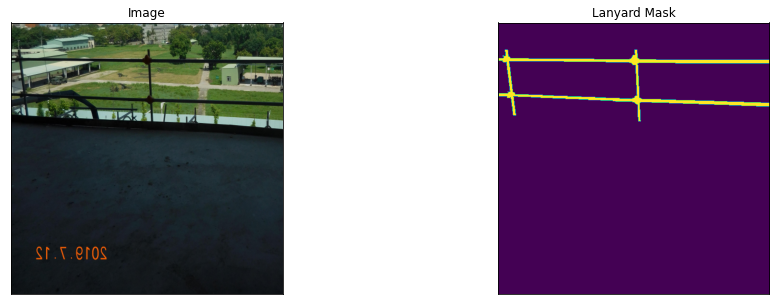

In [33]:
image, mask = train_dataset_vis[100]
print(image.shape)
print(mask.shape)
visualize(
    image=image, 
    lanyard_mask=mask[..., 0].squeeze(),
)

In [34]:
train_dataset = IS_Dataset(
  input_train, 
  output_train, 
  transform=transform,
  transform_toTensor=transform_toTensor,
  classes=classes,
  cm2lbl=cm2lbl
  )
validation_dataset = IS_Dataset(
  input_vali, 
  output_vali,
  classes=classes,
  transform=transform, 
  transform_toTensor=transform_toTensor,
  cm2lbl=cm2lbl
  )
  
train_dataloader = DataLoader(train_dataset, 8, shuffle=True, num_workers=2, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, 1, shuffle=False, num_workers=2, drop_last=True)

Read 633 images
Read 159 images


In [35]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))  

In [36]:
image_datasets = {
    'train': train_dataset, 'val': validation_dataset
}

dataloaders = {
    'train': train_dataloader,
    'val': validation_dataloader
}

def train_model(model, optimizer, scheduler, num_epochs=25, best_model_path=None):
    
    if best_model_path:
        print("Loading best model weight")
        model = torch.load(best_model_path)
        best_model_wts = model.state_dict()
        model.load_state_dict(best_model_wts)
    else:
        best_model_wts = copy.deepcopy(model.state_dict())
        
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        if ((epoch % 5) == 0) and (epoch > 1):
            weight_path = '/home/user/Desktop/lanyard_segmentation/0425/backups_DeepLabv3plus_mobilenet_ghost/model_'+ str(epoch+1) +'.pth'
            torch.save(model,weight_path)
            print("save model")
            
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                
                torch.save(model,'/home/user/Desktop/lanyard_segmentation/0425/backups_DeepLabv3plus_mobilenet_ghost/best_model.pth')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
num_epochs = 25
model = DeepLabv3_plus_mobilenet(nInputChannels=3, n_classes=1, os=8, pretrained=False, _print=True).to(device)
weight_decay = 1e-4
max_lr = 5e-4
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay=weight_decay)
lambda1 = lambda epoch: (1-epoch/num_epochs) ** 0.9

exp_lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_ft, lr_lambda=[lambda1])
# exp_lr_scheduler.get_lr()
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)
# bm_path = '/kaggle/input/unet-17epoch/best_model.pt'
torch.cuda.is_available()
print_network(model)

cuda:0
Constructing DeepLabv3+ model...
Number of classes: 1
Output stride: 8
Number of Input Channels: 3
DeepLabv3_plus_mobilenet(
  (efficient_features): MobileNetV2(
    (features): Sequential(
      (0): Sequential(
        (0): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (cheap_operation): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
        )
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): Batch

In [38]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs, best_model_path=None)

Epoch 0/24
----------
LR 0.00048196346062927547


/home/user/anaconda3/envs/jamie_segmentation/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/user/anaconda3/envs/jamie_segmentation/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.323173, dice: 0.871200, loss: 0.597186
val: bce: 0.265471, dice: 0.851918, loss: 0.558695
saving best model
0m 53s
Epoch 1/24
----------
LR 0.0004638515892816641
train: bce: 0.231588, dice: 0.800083, loss: 0.515836
val: bce: 0.213731, dice: 0.799220, loss: 0.506476
saving best model
0m 51s
Epoch 2/24
----------
LR 0.00044566077304449995
train: bce: 0.218597, dice: 0.741966, loss: 0.480281
val: bce: 0.209437, dice: 0.727542, loss: 0.468490
saving best model
0m 51s
Epoch 3/24
----------
LR 0.00042738705301356716
train: bce: 0.202912, dice: 0.680782, loss: 0.441847
val: bce: 0.206334, dice: 0.690426, loss: 0.448380
saving best model
0m 53s
Epoch 4/24
----------
LR 0.00040902607302542923
train: bce: 0.201299, dice: 0.651797, loss: 0.426548
val: bce: 0.188063, dice: 0.653300, loss: 0.420682
saving best model
0m 51s
Epoch 5/24
----------
save model
LR 0.0003905730178340304
train: bce: 0.197259, dice: 0.630330, loss: 0.413794
val: bce: 0.190739, dice: 0.612878, loss: 0.401808
sa

# Test

In [39]:
def ratioFunction(num1, num2):
    num1 = int(num1) # Now we are good
    num2 = int(num2) # Good, good
    if num1 > num2:
        ratio12 = num2/num1
    else:
        ratio12 = num1/num2
#     print('The ratio of', num1, 'and', num2,'is', ratio12 + '.')
    return ratio12
ratioFunction(288, 216)

0.75

In [40]:
class IS_Dataset_test(Dataset):
  CLASSES = ['background', 'girder', 'net', 'lanyard', 'guardrail']
  def __init__(self, data_list, label_list, classes, cm2lbl, transform=None, transform_toTensor=None, resize_size=None):

    self.data_list = data_list
    self.label_list = label_list
    self.transform = transform
    self.transform_toTensor = transform_toTensor
    self.cm2lbl = cm2lbl
    self.resize_size = resize_size
    # convert str names to class values on masks
    self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    print('Read ' + str(len(self.data_list)) + ' images')
    
  def __getitem__(self, index):
    # read data
    image = cv2.imread(self.data_list[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, self.resize_size, interpolation=cv2.INTER_AREA)
        
    mask = cv2.imread(self.label_list[index])
#     mask = cv2.resize(mask, self.resize_size, interpolation=cv2.INTER_NEAREST)
    if self.resize_size:
        image = cv2.resize(image, self.resize_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, self.resize_size, interpolation=cv2.INTER_NEAREST)
    if image.shape[0] > 1400 or image.shape[1] > 1400 :
        ratio = ratioFunction(image.shape[0], image.shape[1])
        new_size = (960, int(960*ratio))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)
        
    print(image.shape)
    # apply data augmentations
    if self.transform:
      # ndarray to PIL image
      image = Image.fromarray(image)
      mask = Image.fromarray(mask)
      # apply the transforms
      image = self.transform(image)
      mask = self.transform(mask)

    #把RGB改成0,1,...,class_num : (w, w, 1)
    mask = image2label(mask, self.cm2lbl)
    mask = mask.squeeze()
    # print(np.unique(mask))
    # print(mask.shape)

    # 把每個不同目標分成0,1 : (w, w, class_num)
    masks = [(mask == v) for v in self.class_values]
    mask = np.stack(masks, axis=-1).astype('float')

    if self.transform_toTensor:
      image = self.transform_toTensor(image)
      mask = self.transform_toTensor(mask)

    return image, mask
    
  def __len__(self):
    return len(self.data_list)

In [41]:
def label_viz(pr_mask_gray_uni_list, pr_mask_gray, image_vis, classes):
  idx = range(len(pr_mask_gray_uni_list))

  vis_dict = dict(zip(pr_mask_gray_uni_list, idx))

  pr_mask_viz = pr_mask_gray
    
  for i in range(pr_mask_viz.shape[0]):
    for j in range(pr_mask_viz.shape[1]):
      pr_mask_viz[i][j] = vis_dict[pr_mask_viz[i][j]]

  pr_mask_viz = pr_mask_viz.astype(np.int32)
  print('pr_mask_viz shape: ',pr_mask_viz.shape)
  lbl_viz = imgviz.label2rgb(
      label=pr_mask_viz, image=imgviz.asgray(image_vis), label_names=classes, loc="rb"
  )
  
  return lbl_viz

In [42]:
viz_classes = ['guardrail']
classes = ['guardrail']

In [43]:
def random_vis_lanyard_re(weight_path, classes, test_features_folder, test_labels_folder, prefix=None):
  best_model = torch.load(weight_path + '/best_model.pth')
  test_input_imgs = read_images(test_features_folder)
  test_output_imgs = read_images(test_labels_folder)

  cm2lbl = make_cm2lbl()

  test_dataset = IS_Dataset_test(
      test_input_imgs, 
      test_output_imgs, 
#       transform=transform,
      transform_toTensor=transform_toTensor,
      classes=classes,
      cm2lbl=cm2lbl
   )
  test_dataset_vis = IS_Dataset_test(test_input_imgs, test_output_imgs, classes=classes, cm2lbl=cm2lbl)

  test_resized_dataset = IS_Dataset(
      test_input_imgs, 
      test_output_imgs, 
#       transform=transform,
      transform_toTensor=transform_toTensor,
      classes=classes,
      cm2lbl=cm2lbl,resize_size=(512,512)
  )
  
  
  for i in tqdm(range(20)):
#     n = np.random.choice(len(test_dataset))
    n = i
    image_vis = test_dataset_vis[n][0].astype('uint8')

    image, gt_mask = test_dataset[n]
    image_resized, gt_mask_resized = test_resized_dataset[n]
    
    gt_mask = gt_mask.squeeze()
#     gt_mask_tensor = torch.from_numpy(gt_mask)
    gt_mask_tensor = gt_mask
    
    gt_mask_resized = gt_mask_resized.squeeze()
    
#     x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)
    torch.cuda.empty_cache()
    x_tensor = image.to('cuda').unsqueeze(0)
    pr_mask = best_model(x_tensor).data
    pr_mask = torch.sigmoid(pr_mask)
#     print('pr_mask unique :', np.unique(pr_mask.squeeze().cpu().numpy()))
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    
#     x_tensor_resized = torch.from_numpy(image_resized).to('cuda').unsqueeze(0)
    x_tensor_resized = image_resized.to('cuda').unsqueeze(0)
    print('pr_mask shape:', pr_mask.shape)
    pr_mask_resized = best_model(x_tensor_resized).data
    pr_mask_resized = torch.sigmoid(pr_mask_resized)
    pr_mask_resized = (pr_mask_resized.squeeze().cpu().numpy().round())
    pr_mask_resized_return = cv2.resize(pr_mask_resized, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
#     print('pr_mask_resized_return shape:', pr_mask_resized_return.shape)
    pr_mask_resized_return_uni = np.unique(pr_mask_resized_return)
    pr_mask_resized_return_uni_list = pr_mask_resized_return_uni.tolist()
    
    

    # save_images(save_img_dir, prefix_img, 
    #       image=image_vis, 
    #       ground_truth_mask=gt_mask, 
    #       predicted_mask=pr_mask,
    #       prediced_resized_mask=pr_mask_resized_return,
    #       mask_viz = lbl_viz
    # )

    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask,
        prediced_resized_mask=pr_mask_resized_return,
#         lbl_viz = lbl_viz
    )



In [44]:
weight_path = '/home/user/Desktop/lanyard_segmentation/0425/backups_DeepLabv3plus_mobilenet_ghost'
test_features_folder = '/home/user/Desktop/lanyard_segmentation/guardrail/test_data/features'
test_labels_folder = '/home/user/Desktop/lanyard_segmentation/guardrail/test_data/labels'
orig_features_folder = '/home/user/Desktop/lanyard_segmentation/guardrail/orig_features'
orig_labels_folder = '/home/user/Desktop/lanyard_segmentation/guardrail/orig_labels'

In [ ]:
random_vis_lanyard_re(weight_path, classes, test_features_folder, test_labels_folder)

In [ ]:
random_vis_lanyard_re(weight_path, classes, orig_features_folder, orig_labels_folder)

In [47]:
# F.iou(y_pr, y_gt, eps=1e-7, threshold=0.5, ignore_channels=None)
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold)
    else:
        return x
    
def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union


In [48]:
def test_lanyard_re(weight_path, classes, test_features_folder, test_labels_folder, prefix=None):
  iou_scores = []
  iou_scores_resized = []
  best_model = torch.load(weight_path + '/best_model.pth')
  test_input_imgs = read_images(test_features_folder)
  test_output_imgs = read_images(test_labels_folder)

  cm2lbl = make_cm2lbl()

  test_dataset = IS_Dataset_test(
      test_input_imgs, 
      test_output_imgs, 
#       transform=transform,
      transform_toTensor=transform_toTensor,
      classes=classes,
      cm2lbl=cm2lbl
   )
  test_dataset_vis = IS_Dataset_test(test_input_imgs, test_output_imgs, classes=classes, cm2lbl=cm2lbl)

  test_resized_dataset = IS_Dataset(
      test_input_imgs, 
      test_output_imgs, 
#       transform=transform,
      transform_toTensor=transform_toTensor,
      classes=classes,
      cm2lbl=cm2lbl,resize_size=(512,512)
  )
  
  
  for i in tqdm(range(len(test_dataset))):
    image_vis = test_dataset_vis[i][0].astype('uint8')

    image, gt_mask = test_dataset[i]
    image_resized, gt_mask_resized = test_resized_dataset[i]
    
    gt_mask = gt_mask.squeeze()
#     gt_mask_tensor = torch.from_numpy(gt_mask)
    gt_mask_tensor = gt_mask
    
    gt_mask_resized = gt_mask_resized.squeeze()
    
#     x_tensor = torch.from_numpy(image).to('cuda').unsqueeze(0)
    x_tensor = image.to('cuda').unsqueeze(0)
    pr_mask = best_model(x_tensor).data
    pr_mask = torch.sigmoid(pr_mask)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask_tensor = torch.from_numpy(pr_mask)
    
#     x_tensor_resized = torch.from_numpy(image_resized).to('cuda').unsqueeze(0)
    x_tensor_resized = image_resized.to('cuda').unsqueeze(0)
    pr_mask_resized = best_model(x_tensor_resized).data
    pr_mask_resized = torch.sigmoid(pr_mask_resized)
    pr_mask_resized = (pr_mask_resized.squeeze().cpu().numpy().round())
    pr_mask_resized_return = cv2.resize(pr_mask_resized, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    pr_mask_resized_return_tensor = torch.from_numpy(pr_mask_resized_return)
    
    iou_score = iou(pr_mask_tensor, gt_mask_tensor, eps=1e-7, threshold=0.5, ignore_channels=None)
    iou_score_resized = iou(pr_mask_resized_return_tensor, gt_mask_tensor, eps=1e-7, threshold=0.5, ignore_channels=None)
    iou_scores.append(iou_score)
    iou_scores_resized.append(iou_score_resized)
    

  return np.mean(iou_scores), np.mean(iou_scores_resized)

In [49]:
iou_scores, iou_scores_resized = test_lanyard_re(weight_path, classes, test_features_folder, test_labels_folder)

path： /home/user/Desktop/lanyard_segmentation/guardrail/test_data/features
directory： []
file： ['0075.png', '0086.png', '0019.png', '0083.png', '0054.png', '0001.png', '0050.png', '0056.png', '0058.png', '0084.png', '0081.png', '0034.png', '0023.png']


100%|██████████| 13/13 [00:00<00:00, 389471.09it/s]


Read  13  files
path： /home/user/Desktop/lanyard_segmentation/guardrail/test_data/labels
directory： []
file： ['0075.png', '0086.png', '0019.png', '0083.png', '0054.png', '0001.png', '0050.png', '0056.png', '0058.png', '0084.png', '0081.png', '0034.png', '0023.png']


100%|██████████| 13/13 [00:00<00:00, 400926.12it/s]


Read  13  files
Read 13 images
Read 13 images
Read 13 images



  0%|          | 0/13 [00:00<?, ?it/s]

(720, 960, 3)
(720, 960, 3)



  8%|▊         | 1/13 [00:01<00:12,  1.07s/it]

(720, 960, 3)
(720, 960, 3)



 15%|█▌        | 2/13 [00:02<00:11,  1.08s/it]

(720, 960, 3)
(720, 960, 3)



 23%|██▎       | 3/13 [00:03<00:10,  1.05s/it]

(720, 960, 3)
(720, 960, 3)



 31%|███       | 4/13 [00:04<00:09,  1.06s/it]

(720, 960, 3)
(720, 960, 3)



 38%|███▊      | 5/13 [00:05<00:07,  1.03it/s]

(720, 960, 3)
(720, 960, 3)



 46%|████▌     | 6/13 [00:05<00:06,  1.06it/s]

(720, 960, 3)
(720, 960, 3)



 54%|█████▍    | 7/13 [00:06<00:05,  1.13it/s]

(720, 960, 3)
(720, 960, 3)



 62%|██████▏   | 8/13 [00:07<00:04,  1.15it/s]

(720, 960, 3)
(720, 960, 3)


 77%|███████▋  | 10/13 [00:08<00:02,  1.49it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)



 85%|████████▍ | 11/13 [00:08<00:01,  1.94it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]

(719, 960, 3)
(719, 960, 3)


In [50]:
# test on test set
print(iou_scores)
print(iou_scores_resized)

0.5978054752862664
0.46440089906734894


In [51]:
iou_scores, iou_scores_resized = test_lanyard_re(weight_path, classes, orig_features_folder, orig_labels_folder)

path： /home/user/Desktop/lanyard_segmentation/guardrail/orig_features
directory： []
file： ['0075.png', '0028.png', '0022.png', '0086.png', '0003.png', '0057.png', '0020.png', '0074.png', '0019.png', '0079.png', '0083.png', '0051.png', '0047.png', '0072.png', '0031.png', '0071.png', '0030.png', '0015.png', '0070.png', '0068.png', '0018.png', '0017.png', '0067.png', '0052.png', '0060.png', '0037.png', '0039.png', '0088.png', '0027.png', '0054.png', '0001.png', '0038.png', '0050.png', '0077.png', '0024.png', '0013.png', '0056.png', '0016.png', '0009.png', '0061.png', '0066.png', '0045.png', '0055.png', '0059.png', '0064.png', '0026.png', '0025.png', '0058.png', '0063.png', '0046.png', '0084.png', '0069.png', '0004.png', '0078.png', '0065.png', '0012.png', '0035.png', '0042.png', '0002.png', '0076.png', '0081.png', '0034.png', '0062.png', '0053.png', '0010.png', '0023.png', '0032.png', '0082.png', '0006.png', '0029.png', '0073.png', '0008.png', '0036.png', '0043.png', '0080.png', '0021.png

100%|██████████| 88/88 [00:00<00:00, 1299643.49it/s]


Read  88  files
path： /home/user/Desktop/lanyard_segmentation/guardrail/orig_labels
directory： []
file： ['0075.png', '0028.png', '0022.png', '0086.png', '0003.png', '0057.png', '0020.png', '0074.png', '0019.png', '0079.png', '0083.png', '0051.png', '0047.png', '0072.png', '0031.png', '0071.png', '0030.png', '0015.png', '0070.png', '0068.png', '0018.png', '0017.png', '0067.png', '0052.png', '0060.png', '0037.png', '0039.png', '0088.png', '0027.png', '0054.png', '0001.png', '0038.png', '0050.png', '0077.png', '0024.png', '0013.png', '0056.png', '0016.png', '0009.png', '0061.png', '0066.png', '0045.png', '0055.png', '0059.png', '0064.png', '0026.png', '0025.png', '0058.png', '0063.png', '0046.png', '0084.png', '0069.png', '0004.png', '0078.png', '0065.png', '0012.png', '0035.png', '0042.png', '0002.png', '0076.png', '0081.png', '0034.png', '0062.png', '0053.png', '0010.png', '0023.png', '0032.png', '0082.png', '0006.png', '0029.png', '0073.png', '0008.png', '0036.png', '0043.png', '0080.p

100%|██████████| 88/88 [00:00<00:00, 1724760.52it/s]


Read  88  files
Read 88 images
Read 88 images
Read 88 images



  0%|          | 0/88 [00:00<?, ?it/s]

(720, 960, 3)
(720, 960, 3)


  2%|▏         | 2/88 [00:01<00:48,  1.77it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)



  3%|▎         | 3/88 [00:01<00:32,  2.62it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)


  6%|▌         | 5/88 [00:01<00:20,  4.02it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)



  7%|▋         | 6/88 [00:01<00:18,  4.47it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)


  9%|▉         | 8/88 [00:02<00:15,  5.13it/s]

(719, 960, 3)
(719, 960, 3)
(540, 960, 3)



 10%|█         | 9/88 [00:02<00:15,  5.16it/s]

(540, 960, 3)
(720, 960, 3)
(720, 960, 3)


 12%|█▎        | 11/88 [00:02<00:14,  5.34it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)



 14%|█▎        | 12/88 [00:03<00:14,  5.34it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


 16%|█▌        | 14/88 [00:03<00:13,  5.52it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)



 17%|█▋        | 15/88 [00:03<00:13,  5.61it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)


 19%|█▉        | 17/88 [00:03<00:12,  5.74it/s]

(719, 960, 3)
(719, 960, 3)
(720, 960, 3)
(720, 960, 3)



 20%|██        | 18/88 [00:05<00:32,  2.13it/s]

(720, 960, 3)
(720, 960, 3)



 22%|██▏       | 19/88 [00:06<00:48,  1.43it/s]

(720, 960, 3)
(720, 960, 3)



 23%|██▎       | 20/88 [00:07<00:58,  1.16it/s]

(720, 960, 3)
(720, 960, 3)



 24%|██▍       | 21/88 [00:08<01:03,  1.05it/s]

(720, 960, 3)
(720, 960, 3)



 25%|██▌       | 22/88 [00:09<01:06,  1.01s/it]

(720, 960, 3)
(720, 960, 3)



 26%|██▌       | 23/88 [00:10<01:07,  1.03s/it]

(720, 960, 3)
(720, 960, 3)



 27%|██▋       | 24/88 [00:12<01:09,  1.09s/it]

(720, 960, 3)
(720, 960, 3)



 28%|██▊       | 25/88 [00:13<01:09,  1.11s/it]

(720, 960, 3)
(720, 960, 3)



 30%|██▉       | 26/88 [00:14<01:10,  1.13s/it]

(720, 960, 3)
(720, 960, 3)



 31%|███       | 27/88 [00:15<01:09,  1.14s/it]

(720, 960, 3)
(720, 960, 3)



 32%|███▏      | 28/88 [00:16<01:08,  1.14s/it]

(720, 960, 3)
(720, 960, 3)



 33%|███▎      | 29/88 [00:17<01:05,  1.11s/it]

(720, 960, 3)
(720, 960, 3)



 34%|███▍      | 30/88 [00:18<01:03,  1.10s/it]

(720, 960, 3)
(720, 960, 3)



 35%|███▌      | 31/88 [00:20<01:03,  1.11s/it]

(720, 960, 3)
(720, 960, 3)



 36%|███▋      | 32/88 [00:21<01:01,  1.09s/it]

(720, 960, 3)
(720, 960, 3)



 38%|███▊      | 33/88 [00:22<01:00,  1.11s/it]

(720, 960, 3)
(720, 960, 3)



 39%|███▊      | 34/88 [00:23<01:01,  1.13s/it]

(720, 960, 3)
(720, 960, 3)



 40%|███▉      | 35/88 [00:24<01:00,  1.14s/it]

(720, 960, 3)
(720, 960, 3)



 41%|████      | 36/88 [00:25<00:58,  1.13s/it]

(720, 960, 3)
(720, 960, 3)



 42%|████▏     | 37/88 [00:26<00:56,  1.11s/it]

(720, 960, 3)
(720, 960, 3)



 43%|████▎     | 38/88 [00:27<00:56,  1.12s/it]

(720, 960, 3)
(720, 960, 3)



 44%|████▍     | 39/88 [00:29<00:54,  1.12s/it]

(720, 960, 3)
(720, 960, 3)



 45%|████▌     | 40/88 [00:30<00:54,  1.13s/it]

(720, 960, 3)
(720, 960, 3)



 47%|████▋     | 41/88 [00:31<00:54,  1.15s/it]

(720, 960, 3)
(720, 960, 3)



 48%|████▊     | 42/88 [00:32<00:52,  1.15s/it]

(720, 960, 3)
(720, 960, 3)



 49%|████▉     | 43/88 [00:33<00:52,  1.16s/it]

(720, 960, 3)
(720, 960, 3)



 50%|█████     | 44/88 [00:34<00:50,  1.15s/it]

(720, 960, 3)
(720, 960, 3)



 51%|█████     | 45/88 [00:35<00:46,  1.08s/it]

(720, 960, 3)
(720, 960, 3)



 52%|█████▏    | 46/88 [00:36<00:42,  1.02s/it]

(720, 960, 3)
(720, 960, 3)



 53%|█████▎    | 47/88 [00:37<00:39,  1.04it/s]

(720, 960, 3)
(720, 960, 3)



 55%|█████▍    | 48/88 [00:38<00:36,  1.09it/s]

(720, 960, 3)
(720, 960, 3)



 56%|█████▌    | 49/88 [00:39<00:34,  1.13it/s]

(720, 960, 3)
(720, 960, 3)



 57%|█████▋    | 50/88 [00:39<00:33,  1.15it/s]

(720, 960, 3)
(720, 960, 3)



 58%|█████▊    | 51/88 [00:40<00:30,  1.19it/s]

(720, 960, 3)
(720, 960, 3)



 59%|█████▉    | 52/88 [00:41<00:29,  1.21it/s]

(720, 960, 3)
(720, 960, 3)



 60%|██████    | 53/88 [00:42<00:29,  1.18it/s]

(720, 960, 3)
(720, 960, 3)



 61%|██████▏   | 54/88 [00:43<00:29,  1.17it/s]

(720, 960, 3)
(720, 960, 3)



 62%|██████▎   | 55/88 [00:44<00:28,  1.16it/s]

(720, 960, 3)
(720, 960, 3)



 64%|██████▎   | 56/88 [00:44<00:27,  1.18it/s]

(720, 960, 3)
(720, 960, 3)



 65%|██████▍   | 57/88 [00:45<00:26,  1.18it/s]

(720, 960, 3)
(720, 960, 3)



 66%|██████▌   | 58/88 [00:46<00:25,  1.19it/s]

(720, 960, 3)
(720, 960, 3)



 67%|██████▋   | 59/88 [00:47<00:23,  1.23it/s]

(720, 960, 3)
(720, 960, 3)



 68%|██████▊   | 60/88 [00:48<00:23,  1.22it/s]

(720, 960, 3)
(720, 960, 3)



 69%|██████▉   | 61/88 [00:49<00:22,  1.18it/s]

(720, 960, 3)
(720, 960, 3)



 70%|███████   | 62/88 [00:49<00:22,  1.17it/s]

(720, 960, 3)
(720, 960, 3)



 72%|███████▏  | 63/88 [00:50<00:21,  1.17it/s]

(720, 960, 3)
(720, 960, 3)



 73%|███████▎  | 64/88 [00:51<00:19,  1.21it/s]

(720, 960, 3)
(720, 960, 3)



 74%|███████▍  | 65/88 [00:52<00:18,  1.22it/s]

(720, 960, 3)
(720, 960, 3)



 75%|███████▌  | 66/88 [00:53<00:18,  1.21it/s]

(720, 960, 3)
(720, 960, 3)



 76%|███████▌  | 67/88 [00:54<00:17,  1.22it/s]

(720, 960, 3)
(720, 960, 3)


 78%|███████▊  | 69/88 [00:54<00:11,  1.64it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)



 80%|███████▉  | 70/88 [00:55<00:08,  2.07it/s]

(540, 960, 3)
(540, 960, 3)
(540, 960, 3)



 81%|████████  | 71/88 [00:55<00:06,  2.55it/s]

(720, 960, 3)
(720, 960, 3)



 82%|████████▏ | 72/88 [00:56<00:08,  1.83it/s]

(720, 960, 3)
(720, 960, 3)



 83%|████████▎ | 73/88 [00:57<00:09,  1.53it/s]

(720, 960, 3)
(720, 960, 3)



 84%|████████▍ | 74/88 [00:58<00:10,  1.36it/s]

(720, 960, 3)
(720, 960, 3)



 85%|████████▌ | 75/88 [00:59<00:10,  1.25it/s]

(720, 960, 3)
(720, 960, 3)



 86%|████████▋ | 76/88 [00:59<00:09,  1.23it/s]

(360, 640, 3)
(360, 640, 3)
(640, 360, 3)
(640, 360, 3)
(719, 960, 3)
(719, 960, 3)


 91%|█████████ | 80/88 [01:00<00:02,  2.82it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)



 92%|█████████▏| 81/88 [01:00<00:02,  3.23it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)


 94%|█████████▍| 83/88 [01:00<00:01,  4.05it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)



 95%|█████████▌| 84/88 [01:00<00:00,  4.44it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)


 98%|█████████▊| 86/88 [01:01<00:00,  5.04it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)



 99%|█████████▉| 87/88 [01:01<00:00,  5.29it/s]

(719, 960, 3)
(719, 960, 3)
(719, 960, 3)


100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


In [52]:
# test on train set
print(iou_scores)
print(iou_scores_resized)

0.5899774634121236
0.46932527533257234
